# Inverting a colour negative

In this notebook we invert a colour negative with the help of a blank film base.
The sample images were generously provided by [Steve Morton](http://www.stevemortonphotography.co.uk/) and can be downloaded here: [colour negative](https://raw.githubusercontent.com/neothemachine/rawpy-notebooks/master/images/CN005-04.dng), [film base](https://raw.githubusercontent.com/neothemachine/rawpy-notebooks/master/images/_DSC3254.dng).

## Imports
For displaying images in this notebook we first import [matplotlib](http://matplotlib.org/).

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10, 15
from matplotlib.pyplot import imshow

The processing is done with [rawpy](https://pypi.python.org/pypi/rawpy) and [numpy](http://www.numpy.org) which are imported below.

In [2]:
import rawpy
import numpy as np

## Input images

The colour negative:

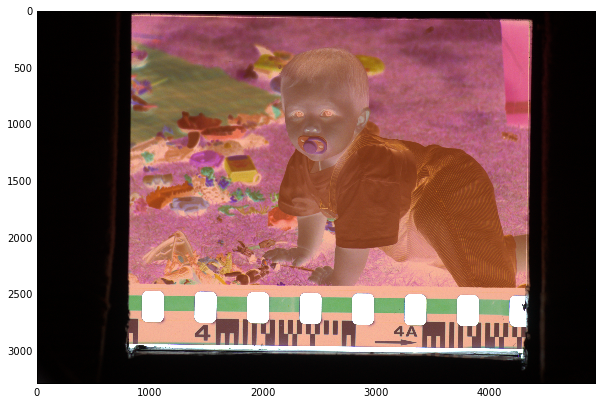

In [3]:
raw_neg = rawpy.imread('../images/CN005-04.dng')
rgb_neg = raw_neg.postprocess()
imshow(rgb_neg)

The blank film base:

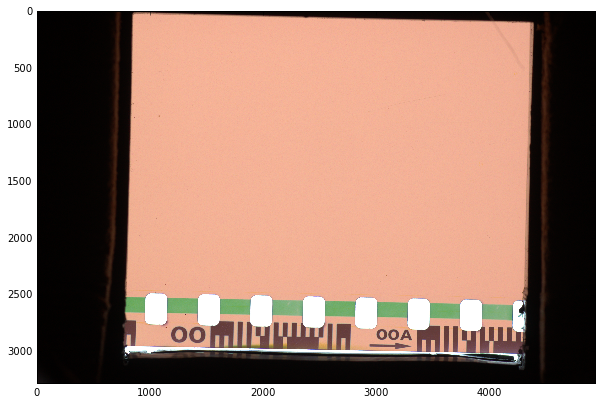

In [4]:
raw_base = rawpy.imread('../images/_DSC3254.dng')
rgb_base = raw_base.postprocess()
imshow(rgb_base)

## Inverting the negative

As can be seen above the film base has an orange cast. We have to remove this colour cast before we invert the image and apply further corrections.

### Step 1: Determine colour balance and brightness multipliers for the film base

By default, rawpy applies several colour and brightness corrections to the RAW image which then lead to good output images for normal photography.
However, here we need to disable all those corrections since we want to determine those ourselves based on the unmodified linear sensor data. The relevant parameters are `output_color`, `gamma`, `user_wb`, and `no_auto_bright`:

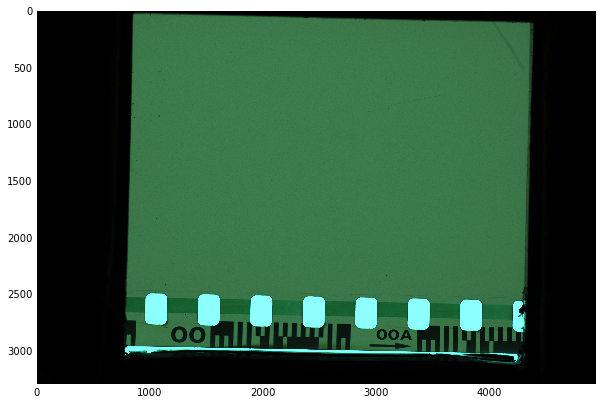

In [5]:
rgb_base_linear = raw_base.postprocess(output_color=rawpy.ColorSpace.raw, gamma=(1, 1),
                                       user_wb=[1.0, 1.0, 1.0, 1.0], no_auto_bright=True)
imshow(rgb_base_linear)

Now we crop the image to a piece of film base on which we will do the calculations. Let's pick a square in the centre:

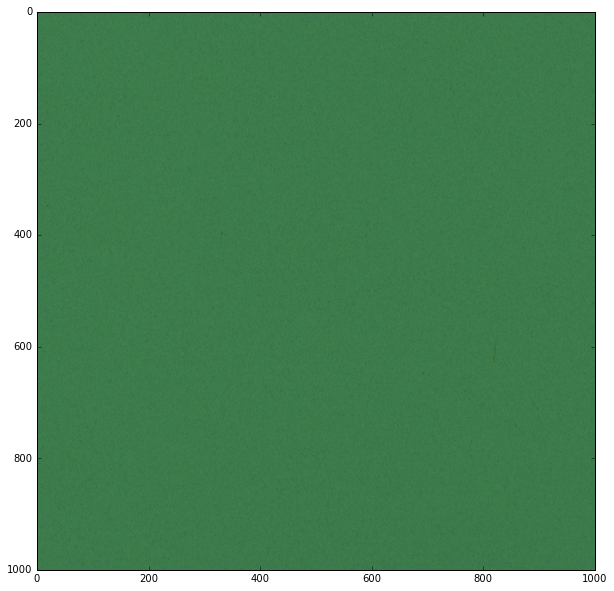

In [6]:
rgb_base_linear_cropped = rgb_base_linear[1000:2000,2000:3000]
imshow(rgb_base_linear_cropped)

Now we calculate the average intensity for each channel with `np.average`.

In [7]:
avg_r = np.average(rgb_base_linear_cropped[..., 0])
avg_g = np.average(rgb_base_linear_cropped[..., 1])
avg_b = np.average(rgb_base_linear_cropped[..., 2])
print(avg_r, avg_g, avg_b)

60.945608 123.097876 75.826987


Typically, those values are now scaled such that one channel becomes 1.0. Here, we scale to the green channel:

In [8]:
base_wb = [avg_g/avg_r, 1.0, avg_g/avg_b, 1.0]
print(base_wb)

[2.0197989656613156, 1.0, 1.6234045538430795, 1.0]


We also estimate the brightness of the image from the green channel. We will later see where we need this value again.

In [9]:
base_brightness = 255/avg_g
print(base_brightness)

2.07152233886


## Step 2: Check corrected film base

Before applying the correction multipliers to the negative we verify that the film base now appears in a neutral gray. If this was not the case then we would have done something wrong.

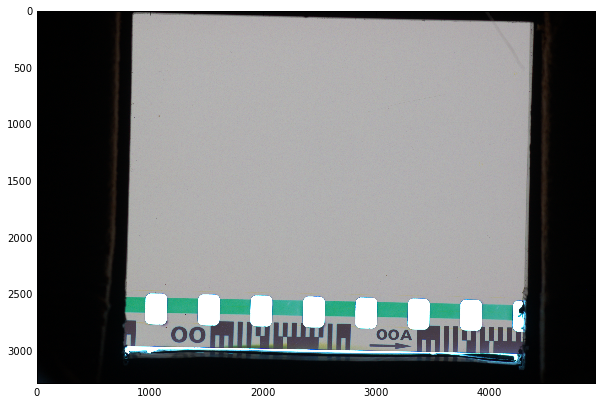

In [10]:
rgb_base_corrected = raw_base.postprocess(user_wb=base_wb)
imshow(rgb_base_corrected)

Apparently, all is fine, so we continue with the negative!

## Step 3: Apply film base correction to colour negative

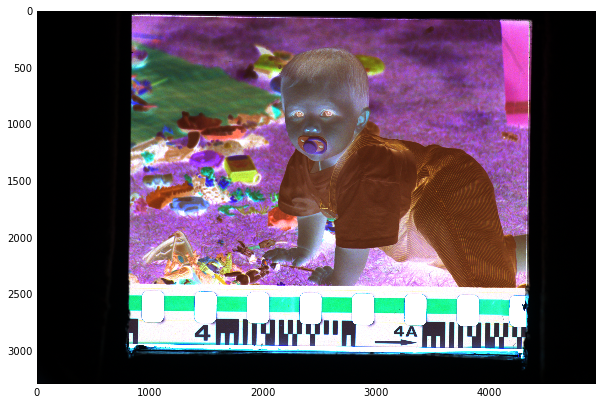

In [11]:
rgb_neg_corrected = raw_neg.postprocess(gamma=(1, 1), user_wb=base_wb, bright=base_brightness, no_auto_bright=True)
imshow(rgb_neg_corrected)

## Step 4: Crop corrected colour negative

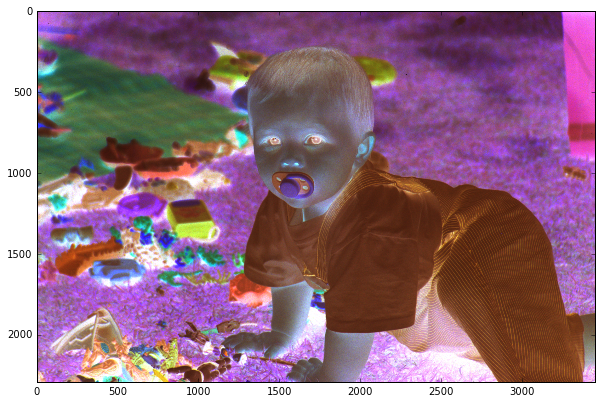

In [12]:
rgb_neg_corrected_cropped = rgb_neg_corrected[108:2400,848:4300]
imshow(rgb_neg_corrected_cropped)

## Step 5: Invert and implicitly set black level

In [13]:
max_r = np.max(rgb_neg_corrected_cropped[..., 0])
max_g = np.max(rgb_neg_corrected_cropped[..., 1])
max_b = np.max(rgb_neg_corrected_cropped[..., 2])
print(max_r, max_g, max_b)

255 255 255


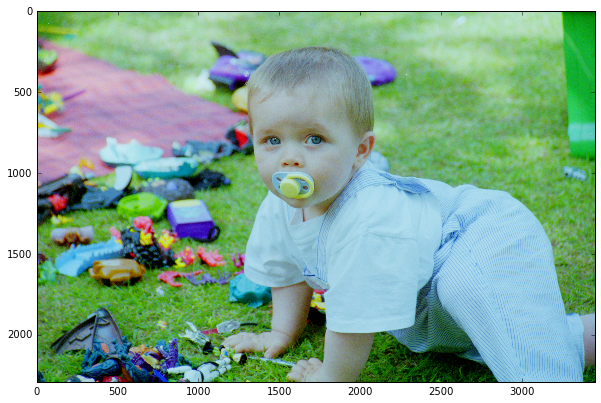

In [14]:
rgb_pos = rgb_neg_corrected_cropped.copy()
rgb_pos[..., 0] = max_r - rgb_pos[..., 0]
rgb_pos[..., 1] = max_g - rgb_pos[..., 1]
rgb_pos[..., 2] = max_b - rgb_pos[..., 2]
imshow(rgb_pos)

Now any remaining corrections (like adjusting the white level, gamma, or white balance) can be done directly on the RGB image data. Since this happens outside of rawpy, we will end the tutorial here.